# Task12 Blending集成学习算法

## 1 知识梳理

### 1.1 Blending集成学习思路
1. 将数据按照一定比例划分为训练集和测试集，其中训练集按照一定比例再次划分为训练集和验证集
2. 创建第一层的多个同质或异质模型
3. 使用训练集数据对第一层模型进行训练，然后使用验证集和测试集进行模型验证和测试，得到`val_predict`，`test_predict`
4. 创建第二层的模型（一般是线性模型），使用`val_predict`作为第二层模型的训练集
5. 使用训练好的第二层模型对`test_predict`进行预测，将得到的结果作为整个测试集的结果

![jupyter](../assets/ch05/3.jpg)

### 1.2 Blending集成学习的优劣
- 优点：方法简单，使用传递的方法进行训练、验证、测试
- 缺点：只使用一部分数据集进行模型验证

## 2 实战练习

### 2.1 Blending集成学习自编程

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


class Blending:
    def __init__(self, X_train, X_val, y_train, y_val, models):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.models = models

    def fit_ensemble(self):
        y_predict = list()
        for name, model in self.models:
            model.fit(self.X_train, self.y_train)
            yhat = model.predict_proba(self.X_val)
            # 将得到的预测值作为blending的第二层模型输入
            y_predict.append(yhat)

        y_predict = np.hstack(y_predict)
        # 构建第二层模型
        self.blender = LogisticRegression()
        # 训练第二层模型
        self.blender.fit(y_predict, y_val)

    def predict_ensemble(self, X_test):
        meta_X = list()
        for name, model in self.models:
            # 第一层模型预测
            yhat = model.predict_proba(X_test)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)
        # 第二层模型预测
        self.y_predict = self.blender.predict(meta_X)
        return self.y_predict

    @staticmethod
    def score(y_test, yhat):
        score = accuracy_score(y_test, yhat)
        print('Blending Accuracy: %.3f' % (score * 100))

### 2.1 教程例题

In [2]:
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score


def get_models():
    models = list()
    models.append(('svm', SVC(probability=True)))
    models.append(('rfc', RandomForestClassifier(
        n_estimators=5, n_jobs=-1, criterion='gini')))
    models.append(('knn', KNeighborsClassifier()))
    return models


def train_test_val_split(X, y):
    # 划分训练集和测试集
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.3, random_state=1)
    print('Train: %s, Val: %s, Test: %s' %
          (X_train.shape, X_val.shape, X_test.shape))
    return X_train, X_val, y_train, y_val, X_test, y_test


X, y = make_blobs(n_samples=10000, centers=2, random_state=1, cluster_std=1.0)
# 划分训练集、验证集、测试集
X_train, X_val, y_train, y_val, X_test, y_test = train_test_val_split(X, y)
# 构建第一层模型
models = get_models()
# 构建Blending对象
blending = Blending(X_train, X_val, y_train, y_val, models)
blending.fit_ensemble()
yhat = blending.predict_ensemble(X_test)

# 进行5次交叉验证
print("交叉验证结果：", cross_val_score(
    blending.blender, yhat.reshape(-1, 1), y_test, cv=5))

# 评估预测效果
blending.score(y_test, yhat)

Train: (5600, 2), Val: (2400, 2), Test: (2000, 2)
交叉验证结果： [1. 1. 1. 1. 1.]
Blending Accuracy: 100.000


### 2.2 使用iris数据集

In [3]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target
features = iris.feature_names
iris_data = pd.DataFrame(X, columns=features)
iris_data['target'] = y
# 数据预处理
# 仅仅考虑0，1类鸢尾花
iris_data = iris_data.loc[iris_data.target.isin([0, 2])]
y = iris_data['target'].values
X = iris_data[['sepal length (cm)', 'sepal width (cm)']].values

# 将分类标签变成二进制编码：

le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
# 划分训练集、验证集、测试集
X_train, X_val, y_train, y_val, X_test, y_test = train_test_val_split(X, y)
# 构建第一层模型
models = get_models()
# 构建Blending对象
blending = Blending(X_train, X_val, y_train, y_val, models)
blending.fit_ensemble()
yhat = blending.predict_ensemble(X_test)

# 评估预测效果
blending.score(y_test, yhat)

Train: (56, 2), Val: (24, 2), Test: (20, 2)
Blending Accuracy: 95.000


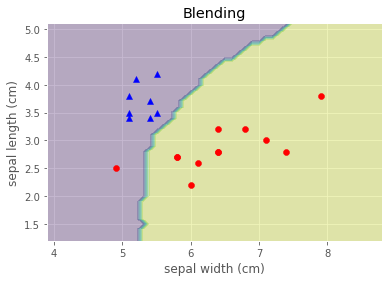

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")

# 画出Blending的决策边界
x_min = X_test[:, 0].min() - 1
x_max = X_test[:, 0].max() + 1
y_min = X_test[:, 1].min() - 1
y_max = X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
yhat = blending.predict_ensemble(np.c_[xx.ravel(), yy.ravel()])
Z = yhat.reshape(-1, 1).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[y_test == 0, 0],
            X_test[y_test == 0, 1], c='blue', marker='^')
plt.scatter(X_test[y_test == 1, 0],
            X_test[y_test == 1, 1], c='red', marker='o')
plt.title('Blending')
plt.ylabel('sepal length (cm)')
plt.xlabel('sepal width (cm)')
plt.show()